In [1]:
from metadensity.metadensity import *
from metadensity.plotd import *
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('/home/hsher/Metadensity/scripts')
from dataloader import *
%matplotlib inline

Using:  /home/hsher/gencode_coords/gencode.v33.transcript.gff3


# Load encode metadata
I have precompiled list of uID and the .bam, .bigWig files in the following dataframe.

# Use some RBP previously documented to interact with intronic polyA sites

In [2]:
master_df.loc[master_df['RBP']=='CPSF6']

,uid,RBP,Cell line,bam_0,bam_1,bam_control,minus_0,minus_1,minus_control,plus_0,...,bed_0,bed_1,Batch,prefix,bam_control_0,bam_control_1,plus_control_0,plus_control_1,minus_control_0,minus_control_1
28,258,CPSF6,K562,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,/projects/ps-yeolab3/encode/analysis/encode_GR...,...,/projects/ps-yeolab5/encode/EVN_eCLIP_analysis...,/projects/ps-yeolab5/encode/EVN_eCLIP_analysis...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
U2AF1 = eCLIP.from_series(encode_data.loc[(encode_data['RBP'] == 'U2AF1')&(encode_data['Cell line'] == 'HepG2')].iloc[0], single_end = False)
U2AF2 = eCLIP.from_series(encode_data.loc[(encode_data['RBP'] == 'U2AF2')&(encode_data['Cell line'] == 'HepG2')].iloc[0], single_end = False)
SF3B4 = eCLIP.from_series(encode_data.loc[(encode_data['RBP'] == 'SF3B4')&(encode_data['Cell line'] == 'HepG2')].iloc[0], single_end = False)
NONO = eCLIP.from_series(encode4_data.loc[(encode4_data['RBP'] == 'NONO')&(encode4_data['Cell line'] == 'HepG2')].iloc[0], single_end = True)
CPSF6 = eCLIP.from_series(encode_data.loc[(encode_data['RBP'] == 'CPSF6')&(encode_data['Cell line'] == 'K562')].iloc[0], single_end = False)
all_clips = [U2AF1,U2AF2,SF3B4, NONO,CPSF6]

# Create custom  feature on metagene, using intronic polyA sites as an example

In [4]:
from metadensity.config import settings

In [5]:
# load polyA sites files
# (in order of decreasing priority: TE, terminal exon; EX, exonic; IN, intronic; DS, 1,000 nt downstream of an annotated terminal exon; AE, anti-sense to an exon; AI, anti-sense to an intron; AU, 1,000 nt upstream in anti-sense direction of a transcription start site; IG, intergenic)
polyadf = pd.read_csv(os.path.join(settings.root_dir, settings.polya_fname), sep = '\t', header = None, names = ['chrom', 'start', 'end', 'name', 'average expression', 'strand', 'perc_sample','n_sample', 'avg_tpm', 'polyatype', 'polyasignal'])
#  two letter code for the cluster annotation (in order of decreasing priority: 
# TE, terminal exon; EX, exonic; IN, intronic; DS, 1,000 nt downstream of an annotated terminal exon; AE, anti-sense to an exon; AI, anti-sense to an intron; AU, 1,000 nt upstream in anti-sense direction of a transcription start site; IG, intergenic)
# the chromosome is listed differently
polyadf['chrom'] = 'chr'+polyadf['chrom'].astype(str)

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3173: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
# make type specific annotation
def extract_polyA_signal_coordinates(subset_polyadf):
    ''' subtracting the coordinate of polyA signal from polya dataframe'''
    # extract polya signals
    signal_coord = []
    for index, row in subset_polyadf.iterrows():
        if type(row['polyasignal'])==str:
            polyasignals = row['polyasignal'].split(';')
            for sig in polyasignals:
                motif, rela_pos, obs_pos = sig.split('@')
                signal_coord.append([row['chrom'],int(obs_pos),int(obs_pos)+1, 
                                     row['name'], row['polyatype'], row['strand']])

    # make into bed
    polysignal_df = pd.DataFrame(signal_coord,
                                columns= ['chrom', 'start', 'end', 'name', 'score', 'strand'])
    polyasignal_bed = BedTool.from_dataframe(polysignal_df)

    return polyasignal_bed
def polyAtype_specific_coords(polyAtype, polyadf = polyadf):
    ''' create polyA related feature for specific types of polyA
    polyAtype can be TE, EX, IN, DS..'''
    # filter for specific types
    subset_polyadf = polyadf.loc[polyadf['polyatype']==polyAtype]
    
    # create bed of polyA sites
    polya_site_bed = BedTool.from_dataframe(subset_polyadf)
    polya_signal_bed = extract_polyA_signal_coordinates(subset_polyadf)
    
    return polya_site_bed, polya_signal_bed

In [7]:
# extract intronic polyA sites and signal
#information about the poly(A) signal(s) that are present upstream of the poly(A) site, 
#including the motif, the location with respect to the cleavage site and the genomic coordinate

polya, polyasignal_bed = polyAtype_specific_coords('IN', polyadf = polyadf)

In [8]:
print(polyasignal_bed[0])

chr1	16467	16468	1:16450:-	IN	-



In [9]:
# determine which transcript these are in
header = ['chrom', 'start', 'end', 'name', 'score', 'strand', 'attr']
polya_site_df = polya.intersect(transcript,s = True, wb = True).to_dataframe(header = None)[[0,1,2,3,4,5,19]]
polysignal_df = polyasignal_bed.intersect(transcript, s = True, wb = True).to_dataframe(header = None)[[0,1,2,3,4,5,14]]
polya_site_df.columns = header
polysignal_df.columns = header

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/pybedtools-0.8.1-py3.7-linux-x86_64.egg/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 20 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())
/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/pybedtools-0.8.1-py3.7-linux-x86_64.egg/pybedtools/bedtool.py:3681: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 15 fields; you can supply custom names with the `names` kwarg
  "`names` kwarg" % (self.file_type, _names, self.field_count())


In [10]:
polysignal_df

,chrom,start,end,name,score,strand,attr
0,chr1,16467,16468,1:16450:-,IN,-,ID=ENST00000488147.1;Parent=ENSG00000227232.5;...
1,chr1,186989,186990,1:186965:-,IN,-,ID=ENST00000623083.4;Parent=ENSG00000279457.4;...
2,chr1,194759,194760,1:194740:-,IN,-,ID=ENST00000623083.4;Parent=ENSG00000279457.4;...
3,chr1,262780,262781,1:262721:-,IN,-,ID=ENST00000441866.2;Parent=ENSG00000228463.10...
4,chr1,262776,262777,1:262721:-,IN,-,ID=ENST00000441866.2;Parent=ENSG00000228463.10...
...,...,...,...,...,...,...,...
236063,chrY,26545751,26545752,Y:26545767:+,IN,+,ID=ENST00000258589.8;Parent=ENSG00000215506.5;...
236064,chrY,26576251,26576252,Y:26576303:+,IN,+,ID=ENST00000258589.8;Parent=ENSG00000215506.5;...
236065,chrY,26576258,26576259,Y:26576303:+,IN,+,ID=ENST00000258589.8;Parent=ENSG00000215506.5;...
236066,chrY,26576272,26576273,Y:26576303:+,IN,+,ID=ENST00000258589.8;Parent=ENSG00000215506.5;...


In [11]:
# extract transcript name
def segment_transcript_name(s):
    return s.split(';')[0].split('=')[1]
polysignal_df['transcript_id']= polysignal_df['attr'].map(segment_transcript_name)
polya_site_df['transcript_id']= polya_site_df['attr'].map(segment_transcript_name)

In [12]:
polya_site_df['transcript_id'].unique().shape

(20649,)

In [13]:
# build metagene from highly expressed
from metadensity.pos_enrich import *
high_exp_meta = highly_exp_biogps('HEPG2')

/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3364: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


Using: /home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/metadensity/data/hg38/gencode
Done building metagene


In [14]:
# check how many of those contain intronic polya sites
polya_site_df.loc[polya_site_df['transcript_id'].isin(high_exp_meta.keys())].shape

(1437, 8)

In [15]:
# add feature to those metagene
for transcript_id in high_exp_meta.keys():
    metagene = high_exp_meta[transcript_id]
    
    # add feature
    sub = polya_site_df.loc[polya_site_df['transcript_id']==transcript_id]
    for index, row in sub.iterrows():
        metagene.create_feature(interval = row['start'], feature_name = 'intron_polyAsite') # POINT FEATURE
    
    sub = polysignal_df.loc[polysignal_df['transcript_id']==transcript_id]
    for index, row in sub.iterrows():
        metagene.create_feature(interval = row['start'], feature_name = 'intron_polyAsig')

In [16]:
# remove metagene that has no intronic polya
for transcript_id in list(high_exp_meta.keys()).copy():
    metagene = high_exp_meta[transcript_id]
    
    if 'intron_polyAsite' not in metagene.featnames or 'intron_polyAsig' not in metagene.featnames:
        del high_exp_meta[transcript_id]

In [17]:
len(high_exp_meta)

147

# extract density from eCLIP

In [18]:
def build_idr_metadensity(eCLIP, metagene = high_exp_meta):
    ''' build metadensity object for eCLIP and its IDR containing transcript'''
    
    m = Metadensity(eCLIP, eCLIP.name+'_intronic_poly', metagenes = metagene,
                   background_method = 'relative information', normalize = False)
    m.get_density_array()
    return m

In [19]:
all_meta = [build_idr_metadensity(e) for e in all_clips]




/home/hsher/miniconda3/envs/metadensity/lib/python3.7/site-packages/metadensity/metadensity.py:613: RuntimeWarning: Mean of empty slice
  feature_average  = np.nanmean(np.stack(all_feature_values), axis = 0)


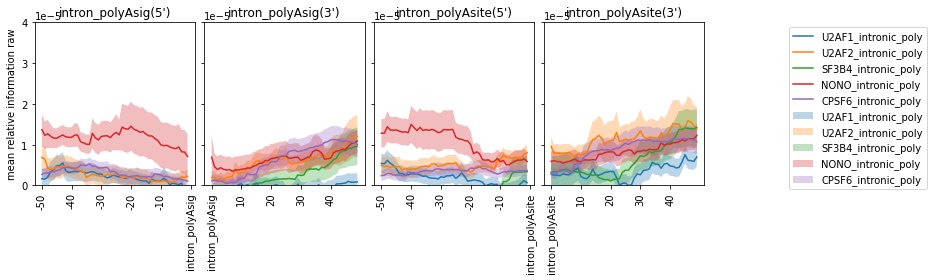

In [20]:

f=plot_mean_density(all_meta,features_to_show = ['intron_polyAsig','intron_polyAsite'], ymax = 0.00004)